In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from tqdm.notebook import tqdm_notebook as tqdm
import os
import csv
from scipy.stats import multivariate_normal

In [2]:
class KMeans:
    def __init__(self, k:int, max_iter:int=10):
        self.k = k
        self.max_iter = max_iter
        
    def initialize(self, X):
        self.N, self.d = X.shape
        shuffled = np.copy(X)
        np.random.seed(6)
        np.random.shuffle(shuffled)
        self.centroids = shuffled[:self.k]
        self.assignment = np.zeros(self.N)
        
    def e_step(self, X):
        for i in range(self.N):
            x = X[i]
            scores = []
            for k in range(self.k):
                scores.append(np.linalg.norm(x - self.centroids[k]))
            self.assignment[i] = np.argmin(scores)
            
    def m_step(self, X):
        for k in range(self.k):
            ind_k = np.where(self.assignment == k)
            X_k = X[ind_k]
            self.centroids[k] = np.mean(X_k, axis=0)

    def fit(self, X):
        self.initialize(X)
        for _ in tqdm(range(self.max_iter),desc='K MEANS CLUSTERING: k='+str(self.k)):
            self.e_step(X)
            self.m_step(X)
        return self.centroids, self.predict(X)
            
    def predict(self, X):
        if(len(X.shape) == 1):
            X = np.array([X])
        N, _ = X.shape
        assignment = np.zeros(N,dtype=np.uint32)
        for i in range(N):
            x = X[i]
            scores = []
            for k in range(self.k):
                scores.append(np.linalg.norm(x - self.centroids[k]))
            assignment[i] = np.argmin(scores)
        # check for empty clusters!
        used = len(np.unique(assignment))
        if(used < self.k):
            print("Empty clusters found! used = ", used, " K = ", self.k)
        return assignment, used

In [3]:
debug = False
class GMM:
    def __init__(self, k:int, max_iter:int =5, max_k_iter:int =10, seed=7):
        self.k = k
        self.max_iter = max_iter 
        self.max_k_iter = max_k_iter
        self.seed = seed
        np.random.seed(seed)

    def initialize(self, X):
        # theta = [Mu, Sigma, Pi]
        n, d = X.shape
        ##################################################
        # USE K Means Engine to initialise (The M0 Step) #
        ##################################################
        kmeans = KMeans(k=self.k, max_iter= self.max_k_iter)
        centroids, (assignment,kprime) = kmeans.fit(X)
        fig, ax = plt.subplots(figsize =(10, 7))
        ax.hist(assignment, bins=np.arange(0, self.k+1, 1))
        
        # Show plot
        plt.show()
        self.mu = np.array(centroids, dtype=np.float64)
        self.sigma = np.array([ np.cov(X.T) for _ in range(self.k) ], dtype=np.float64)
        self.gamma = np.full((n,self.k),fill_value=(1/self.k), dtype=np.float64)
        self.pi = np.mean(self.gamma, axis=0, dtype=np.float64)
                
    def gaussian(x: np.ndarray, mu: np.ndarray, sigma: np.ndarray):
        d = len(x)
        norm_factor = (2*np.pi)**d
        
        mean_sigma = np.mean(sigma)
        det = np.linalg.det(sigma / mean_sigma)
        det = det * (mean_sigma ** len(sigma))
        norm_factor *= det
        norm_factor = 1.0/np.sqrt(np.abs(norm_factor))

        x_mu = np.matrix(x-mu)
        rs = norm_factor*np.exp(-0.5*x_mu*np.linalg.inv(sigma)*x_mu.T)
            
        return rs

    # E-Step: 
    def e_step(self, X):
        n,d = X.shape
        likelihood = np.zeros( (n, self.k) ) 
        for i in range(self.k):
            likelihood[:,i] = multivariate_normal(mean=self.mu[i],cov=self.sigma[i], allow_singular=True, seed=self.seed).pdf(X)
        numerator = likelihood * self.pi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        self.gamma = numerator / denominator
        if(np.isnan(self.gamma).any()):
            print("Anomaly!")
            self.gamma[np.isnan(self.gamma)] = 1/(self.k)
        self.pi = np.mean(self.gamma, axis=0)
        print(self.pi.shape)
        print(self.pi)


    # M-Step: update meu and sigma holding phi and weights constant
    def m_step(self, X):
        for i in range(self.k):
            row_i = self.gamma[:, [i]]
            total_ = row_i.sum()

            self.mu[i] = (X * row_i).sum(axis=0) / total_
            self.sigma[i] = np.cov(X.T,aweights=(row_i/total_).flatten(), bias=True)
            
                

    # responsible for clustering the data points correctly
    def fit(self, X):
        # initialise parameters like weights, phi, meu, sigma of all Gaussians in dataset X
        self.initialize(X)
        for iteration in tqdm(range(self.max_iter),desc='GMM (EM): k='+str(self.k)):
            # iterate to update the value of P(Xi/Ci=j) and (phi)k
            self.e_step(X)
            if(np.isnan(self.mu).any()):
                print("MU IS NAN AFTER E ", iteration+1)
            if(np.isnan(self.sigma).any()):
                print("SIGMA IS NAN AFTER E ", iteration+1)
            if(np.isnan(self.pi).any()):
                print("PI IS NAN AFTER E ", iteration+1)
            if(np.isnan(self.gamma).any()):
                print("GAMMA IS NAN AFTER E ", iteration+1)
            # iterate to update the value of meu and sigma as the clusters shift
            self.m_step(X)
            if(np.isnan(self.mu).any()):
                print("MU IS NAN AFTER M ", iteration+1)
            if(np.isnan(self.sigma).any()):
                print("SIGMA IS NAN AFTER M ", iteration+1)
            if(np.isnan(self.gamma).any()):
                print("GAMMA IS NAN AFTER E ", iteration+1)
            if(np.isnan(self.pi).any()):
                print("PI IS NAN AFTER M ", iteration+1)
    
    # predict function 
    def predict(self, X):
        n,d = np.array(X).shape
        gamma = np.zeros((n,self.k))
        for i in range(n):
            x = X[i]
            p_x = 0.
            vec = []
            for k in range(self.k):
                p_xk = self.pi[k] * (GMM.gaussian(x, self.mu[k], self.sigma[k]))
                vec.append(p_xk.item())
                p_x += p_xk
            if(p_x < 1e-9):
                print("p_x is ", p_x)
            gamma[i] = (np.array(vec, dtype=np.float64))*1.0/p_x
        # self.pi = np.mean(self.gamma, axis=0)
        return np.argmax(gamma, axis=1)
        weights = self.predict_proba(X)
        # datapoint belongs to cluster with maximum probability
        # returns this value
        return np.argmax(weights, axis=1)
    
    def score(self, x, ret_gamma: bool = False):
        # x is d-dimensional single input feature vector
        if(ret_gamma):
            gamma = np.zeros(self.k)
            vec = []
        p_x = 0.
        for k in range(self.k):
            p_xk = self.pi[k] * (GMM.gaussian(x, self.mu[k], self.sigma[k]))
            if(ret_gamma):
                vec.append(p_xk.item())
            p_x += p_xk.item()
        if(ret_gamma):
            gamma = (np.array(vec))*1.0/p_x
            return p_x, gamma
        return p_x
    
    def plot_contour(self, fig, ax, _range, _input, color='red'):
        N, _, d = _input.shape
        if(d != 2):
            print("Can't plot for input not 2d")
            return None
        Z = np.empty((self.k,N,N))
        for k in range(0,self.k):
            for i in range(N):
                for j in range(N):
                    Z[k][i][j] = GMM.gaussian(_input[i][j], self.mu[k], self.sigma[k])
            ax.contour(_input[:,:,0], _input[:,:,1], Z[k], colors=color, levels=np.arange(0.2, 2.0, 0.5))

In [36]:
X = []
Y = []
classes = os.listdir("Features/")
for i in range(len(classes)):
    _class = classes[i]
    inputfiles = os.listdir("Features/"+_class+"/train/")
    for inputfile in inputfiles:
        with open("Features/"+_class+"/train/" + inputfile) as f:
            reader = np.genfromtxt(f, delimiter=" ")
            for row in reader:
                X.append(row)
                Y.append(i)
                
df = pd.DataFrame(X)
df_norm = (df-df.mean())/(df.std())
X = df_norm.to_numpy()
print(X.shape)

(43560, 23)


In [34]:
Y = np.array(Y, dtype=np.float64)
X = np.array(X, dtype=np.float64)
ind1 = np.where(Y == 0)
print(ind1)
ind2 = np.where(Y == 1)
print(ind2)
ind3 = np.where(Y == 2)
print(ind3)
ind4 = np.where(Y == 3)
print(ind4)
ind5 = np.where(Y == 4)
print(ind5)

X1 = X[ind1]
X2 = X[ind2]
X3 = X[ind3]
X4 = X[ind4]
X5 = X[ind5]

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

In [35]:
import numpy as np
from scipy.stats import multivariate_normal 

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter) 

    def initialize(self, X):
        # returns the (r,c) value of the numpy array of X
        self.shape = X.shape 
        # n has the number of rows while m has the number of columns of dataset X
        self.n, self.m = self.shape 
        

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.k, fill_value=1/self.k) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=self.shape, fill_value=1/self.k)
        
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=self.n, size=self.k)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ] 

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ] 
        # theta =(mu1,sigma1,mu2,simga2......muk,sigmak)

    # E-Step: update weights and phi holding mu and sigma constant
    def e_step(self, X):
        # updated weights or P(Xi/Ci=j)
        self.weights = self.predict_proba(X)
        # mean of sum of probability of all data points wrt to one cluster is new updated probability of cluster k or (phi)k
        self.phi = self.weights.mean(axis=0)

    # M-Step: update meu and sigma holding phi and weights constant
    def m_step(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()

            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

    # responsible for clustering the data points correctly
    def fit(self, X):
        # initialise parameters like weights, phi, meu, sigma of all Gaussians in dataset X
        self.initialize(X)
        plt.figure(figsize=(16, 25))
        for iteration in range(self.max_iter):
            # iterate to update the value of P(Xi/Ci=j) and (phi)k
            self.e_step(X)
            # iterate to update the value of meu and sigma as the clusters shift
            self.m_step(X)
            

    # predicts probability of each data point wrt each cluster
    def predict_proba(self, X):
        # Creates a n*k matrix denoting probability of each point wrt each cluster 
        likelihood = np.zeros( (self.n, self.k) ) 
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i],cov=self.sigma[i], allow_singular=True)
            # pdf : probability denisty function
            likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    # predict function 
    def predict(self, X):
        weights = self.predict_proba(X)
        # datapoint belongs to cluster with maximum probability
        # returns this value
        return np.argmax(weights, axis=1)

K MEANS CLUSTERING: k=10:   0%|          | 0/30 [00:00<?, ?it/s]

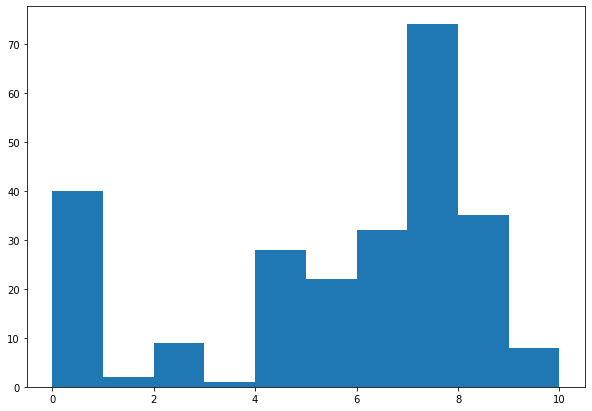

GMM (EM): k=10:   0%|          | 0/30 [00:00<?, ?it/s]

(10,)
[0.16034415 0.00796813 0.03585663 0.00398406 0.11196703 0.0877952
 0.1281205  0.29186367 0.14022811 0.03187252]


C:\Users\Vedant\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_multivariate.py:744: RuntimeWarning: overflow encountered in exp
  return np.exp(self.logpdf(x))
C:\Users\Vedant\AppData\Local\Temp\ipykernel_33712\29434629.py:51: RuntimeWarning: invalid value encountered in true_divide
  self.gamma = numerator / denominator


Anomaly!
(10,)
[0.15936255 0.00796813 0.00358566 0.00039841 0.11155378 0.0876494
 0.12749004 0.29482072 0.13944223 0.00318725]
(10,)
[3.92455748e-39 3.14348825e-01 7.24251931e-11 6.85651174e-01
 9.14042945e-29 6.27246645e-24 5.96902161e-33 7.98715918e-62
 5.02006811e-35 4.00069360e-10]
(10,)
[0.30678636 0.0525627  0.02858961 0.08057698 0.10686341 0.07637425
 0.12351557 0.07171315 0.14012549 0.01289246]
(10,)
[2.64739157e-49 3.30327161e-02 3.18725100e-02 8.42702577e-16
 3.75297679e-09 1.01075379e-04 1.68790957e-14 9.19016775e-01
 4.06643766e-05 1.59362550e-02]
(10,)
[3.11805173e-101 4.56432431e-012 1.07594534e-005 3.14570079e-014
 1.59355534e-002 1.19353528e-002 4.79614722e-041 1.52261424e-157
 1.44798972e-032 9.72118334e-001]
(10,)
[1.19521568e-002 1.88115367e-016 2.85125917e-121 8.80182994e-015
 3.46950750e-002 7.78930360e-001 7.42962175e-014 4.02457645e-125
 1.74422408e-001 2.43954716e-161]
(10,)
[9.98333886e-001 4.09275211e-016 1.79407867e-117 5.45772767e-014
 6.32786840e-122 1.6011

C:\Users\Vedant\AppData\Local\Temp\ipykernel_33712\29434629.py:66: RuntimeWarning: invalid value encountered in true_divide
  self.mu[i] = (X * row_i).sum(axis=0) / total_
C:\Users\Vedant\AppData\Local\Temp\ipykernel_33712\29434629.py:67: RuntimeWarning: invalid value encountered in true_divide
  self.sigma[i] = np.cov(X.T,aweights=(row_i/total_).flatten(), bias=True)


ValueError: array must not contain infs or NaNs

In [35]:
gmm1 = GMM(10, 30, 30)
gmm1.fit(X1)

K MEANS CLUSTERING: k=10:   0%|          | 0/30 [00:00<?, ?it/s]

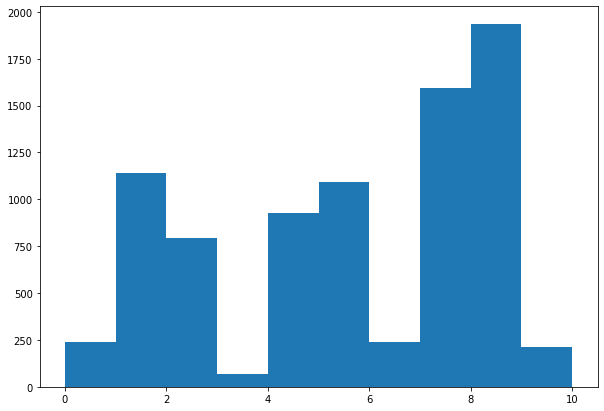

GMM (EM): k=10:   0%|          | 0/30 [00:00<?, ?it/s]

(10,)
[0.02863404 0.1512164  0.097744   0.00995999 0.13316365 0.16347688
 0.02842886 0.1737948  0.18716084 0.02642054]
(10,)
[0.05927774 0.10860446 0.10982743 0.0157811  0.10630403 0.09945199
 0.01472206 0.24667161 0.21405333 0.02530625]
(10,)
[0.043849   0.12132711 0.1220886  0.01119846 0.10290343 0.10486707
 0.01096829 0.26020203 0.20655531 0.01604071]
(10,)
[0.06709594 0.00970368 0.14019828 0.0099104  0.16663874 0.13719618
 0.00698293 0.29752484 0.15680641 0.00794259]
(10,)
[0.04545493 0.00456504 0.15306321 0.00993733 0.0060233  0.19911287
 0.00556625 0.41931332 0.15038701 0.00657674]
(10,)
[0.05884891 0.00370063 0.14024275 0.00855677 0.01787227 0.19759387
 0.00479336 0.44164214 0.12066282 0.00608648]
(10,)
[0.03726725 0.00329448 0.1620393  0.00859784 0.05132903 0.30761459
 0.00434063 0.08218514 0.33752419 0.00580755]
(10,)
[0.04602631 0.00185041 0.13740361 0.00841203 0.05101059 0.28541893
 0.00450494 0.27807461 0.18155092 0.00574765]
(10,)
[0.044799   0.00172575 0.2811312  0.010291

In [24]:
gmm2 = GMM(10, 30, 30)
gmm2.fit(X2)

K MEANS CLUSTERING: k=10:   0%|          | 0/30 [00:00<?, ?it/s]

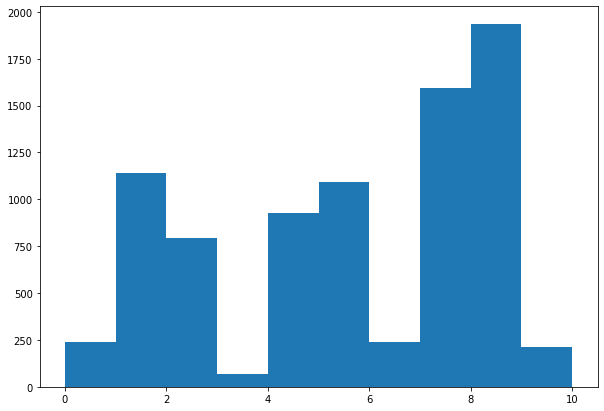

GMM (EM): k=10:   0%|          | 0/30 [00:00<?, ?it/s]

(10,)
[0.02863404 0.1512164  0.097744   0.00995999 0.13316365 0.16347688
 0.02842886 0.1737948  0.18716084 0.02642054]
(10,)
[0.05927774 0.10860446 0.10982743 0.0157811  0.10630403 0.09945199
 0.01472206 0.24667161 0.21405333 0.02530625]
(10,)
[0.043849   0.12132711 0.1220886  0.01119846 0.10290343 0.10486707
 0.01096829 0.26020203 0.20655531 0.01604071]
(10,)
[0.06709594 0.00970368 0.14019828 0.0099104  0.16663874 0.13719618
 0.00698293 0.29752484 0.15680641 0.00794259]
(10,)
[0.04545493 0.00456504 0.15306321 0.00993733 0.0060233  0.19911287
 0.00556625 0.41931332 0.15038701 0.00657674]
(10,)
[0.05884891 0.00370063 0.14024275 0.00855677 0.01787227 0.19759387
 0.00479336 0.44164214 0.12066282 0.00608648]
(10,)
[0.03726725 0.00329448 0.1620393  0.00859784 0.05132903 0.30761459
 0.00434063 0.08218514 0.33752419 0.00580755]
(10,)
[0.04602631 0.00185041 0.13740361 0.00841203 0.05101059 0.28541893
 0.00450494 0.27807461 0.18155092 0.00574765]
(10,)
[0.044799   0.00172575 0.2811312  0.010291

In [25]:
gmm3 = GMM(10, 30, 30)
gmm3.fit(X2)

K MEANS CLUSTERING: k=10:   0%|          | 0/30 [00:00<?, ?it/s]

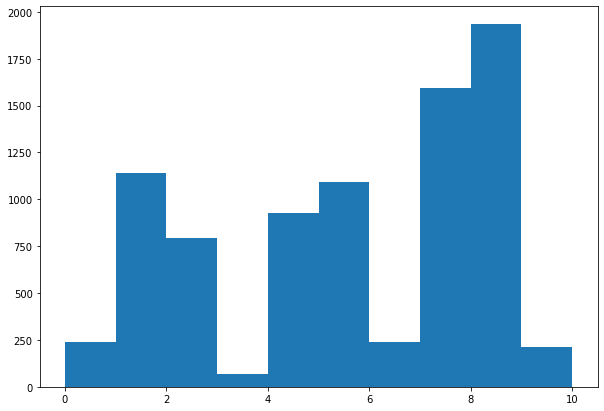

GMM (EM): k=10:   0%|          | 0/30 [00:00<?, ?it/s]

(10,)
[0.02863404 0.1512164  0.097744   0.00995999 0.13316365 0.16347688
 0.02842886 0.1737948  0.18716084 0.02642054]
(10,)
[0.05927774 0.10860446 0.10982743 0.0157811  0.10630403 0.09945199
 0.01472206 0.24667161 0.21405333 0.02530625]
(10,)
[0.043849   0.12132711 0.1220886  0.01119846 0.10290343 0.10486707
 0.01096829 0.26020203 0.20655531 0.01604071]
(10,)
[0.06709594 0.00970368 0.14019828 0.0099104  0.16663874 0.13719618
 0.00698293 0.29752484 0.15680641 0.00794259]
(10,)
[0.04545493 0.00456504 0.15306321 0.00993733 0.0060233  0.19911287
 0.00556625 0.41931332 0.15038701 0.00657674]
(10,)
[0.05884891 0.00370063 0.14024275 0.00855677 0.01787227 0.19759387
 0.00479336 0.44164214 0.12066282 0.00608648]
(10,)
[0.03726725 0.00329448 0.1620393  0.00859784 0.05132903 0.30761459
 0.00434063 0.08218514 0.33752419 0.00580755]
(10,)
[0.04602631 0.00185041 0.13740361 0.00841203 0.05101059 0.28541893
 0.00450494 0.27807461 0.18155092 0.00574765]
(10,)
[0.044799   0.00172575 0.2811312  0.010291

In [26]:
gmm4 = GMM(10, 30, 30)
gmm4.fit(X2)

K MEANS CLUSTERING: k=10:   0%|          | 0/30 [00:00<?, ?it/s]

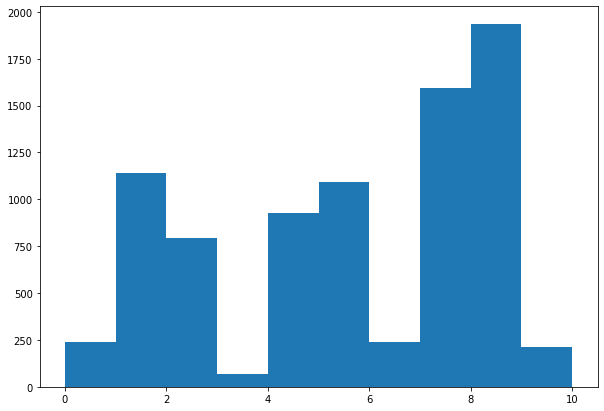

GMM (EM): k=10:   0%|          | 0/30 [00:00<?, ?it/s]

(10,)
[0.02863404 0.1512164  0.097744   0.00995999 0.13316365 0.16347688
 0.02842886 0.1737948  0.18716084 0.02642054]
(10,)
[0.05927774 0.10860446 0.10982743 0.0157811  0.10630403 0.09945199
 0.01472206 0.24667161 0.21405333 0.02530625]
(10,)
[0.043849   0.12132711 0.1220886  0.01119846 0.10290343 0.10486707
 0.01096829 0.26020203 0.20655531 0.01604071]
(10,)
[0.06709594 0.00970368 0.14019828 0.0099104  0.16663874 0.13719618
 0.00698293 0.29752484 0.15680641 0.00794259]
(10,)
[0.04545493 0.00456504 0.15306321 0.00993733 0.0060233  0.19911287
 0.00556625 0.41931332 0.15038701 0.00657674]
(10,)
[0.05884891 0.00370063 0.14024275 0.00855677 0.01787227 0.19759387
 0.00479336 0.44164214 0.12066282 0.00608648]
(10,)
[0.03726725 0.00329448 0.1620393  0.00859784 0.05132903 0.30761459
 0.00434063 0.08218514 0.33752419 0.00580755]
(10,)
[0.04602631 0.00185041 0.13740361 0.00841203 0.05101059 0.28541893
 0.00450494 0.27807461 0.18155092 0.00574765]
(10,)
[0.044799   0.00172575 0.2811312  0.010291

In [27]:
gmm5 = GMM(10, 30, 30)
gmm5.fit(X2)

In [31]:
# import numpy as np
# from sklearn.mixture import GaussianMixture
# # Suppose Data X is a 2-D Numpy array (One apple has two features, size and flavor)
# gmm1 = GaussianMixture(n_components=4, random_state=0).fit(X1)
# gmm2 = GaussianMixture(n_components=4, random_state=0).fit(X2)
# gmm3 = GaussianMixture(n_components=4, random_state=0).fit(X3)
# gmm4 = GaussianMixture(n_components=4, random_state=0).fit(X4)
# gmm5 = GaussianMixture(n_components=4, random_state=0).fit(X5)

In [28]:
X_dev = []
Y_dev = []
classes = os.listdir("Features/")
for i in range(len(classes)):
    _class = classes[i]
    inputfiles = os.listdir("Features/"+_class+"/dev/")
    for inputfile in inputfiles:
        with open("Features/"+_class+"/dev/" + inputfile) as f:
            reader = np.genfromtxt(f, delimiter=" ")
            for row in reader:
                X_dev.append(row)
                Y_dev.append(i)
                
df = pd.DataFrame(X_dev)
df_norm = (df-df.mean())/(df.std())
X_dev = df_norm.to_numpy()
print(X_dev.shape)

(12528, 23)


In [29]:
post1 = lambda x: gmm1.score(x)
post2 = lambda x: gmm2.score(x)
post3 = lambda x: gmm3.score(x)
post4 = lambda x: gmm4.score(x)
post5 = lambda x: gmm5.score(x)
classifier = lambda x : np.argmax([post1(x),post2(x),post3(x),post4(x),post5(x)])

In [44]:
# construct a meshgrid using _range. N = no of sampling points(common for both x1, x2 intervals)
# returns the meshgrid(X1, X2) and Z = result of applying the 3 pdfs(pdf1 with mean mus[0], 
# covariance covs[0] and so on) on the meshgrid
def GridHelper(_range,N,mus,covs):
    X1 = np.linspace(_range[0][0], _range[0][1], N)
    X2 = np.linspace(_range[1][0], _range[1][1], N)
    X1, X2 = np.meshgrid(X1, X2)

    _input = np.empty((N,N,2))
    _input[:,:,0] = X1
    _input[:,:,1] = X2

    return (X1,X2,_input)

In [45]:
# main plotting function
import matplotlib.colors as mcol
from tqdm.notebook import tqdm_notebook as tqdm
def DecisionBoundaryPlotter(_range,mus,covs,data,truth,classifier):

    fig, ax = plt.subplots(figsize=(10, 10))

    # construct grid and apply the three gaussians on it
    print("Making Grid...")
    X1, X2, _input = GridHelper(_range,100,mus,covs)
    print("Done.")

    # plot contours
    gmm1.plot_contour(fig,ax,_range,_input,'red')
    gmm2.plot_contour(fig,ax,_range,_input,'pink')

    # code to apply classifier function to each point on grid and use the result to plot 
    # decision regions
    _x1, _x2 = X1.flatten(), X2.flatten()
    surf = np.empty(_x1.shape)
    print("Evaluating classifier for ", _x1.size, " points...")
    for i in tqdm(range(0,_x1.size)):
        surf[i] = classifier([_x1[i],_x2[i]])
    print("Done.")
    surf = surf.reshape(X1.shape)
    ax.contourf(X1, X2, surf,cmap = mcol.ListedColormap(['orange', 'violet']))

    # code to plot the dev vectors labeled by their true class
    c1x1, c1x2 = [], []
    c2x1, c2x2 = [], []
    _sz = len(data)
    for i in range(0,_sz):
        if truth[i] == 1:
            c1x1.append(data[i][0]), c1x2.append(data[i][1])
        elif truth[i] == 2:
            c2x1.append(data[i][0]), c2x2.append(data[i][1])
    print("Plotting dev data points...")
    ax.scatter(c1x1, c1x2, edgecolors='yellow',label='Class 1 data',s=20,facecolors='none')
    ax.scatter(c2x1, c2x2, edgecolors='blue',label='Class 2 data',s=20,facecolors='none')
    print("Done.")

    # code to label axes and save the plot
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Decision Boundary Diagram')
    ax.legend()
    plt.show()

Making Grid...
Done.
Plotting contours...


  0%|          | 0/14 [00:00<?, ?it/s]

Done
Plotting contours...


  0%|          | 0/16 [00:00<?, ?it/s]

Done
Evaluating classifier for  10000  points...


  0%|          | 0/10000 [00:00<?, ?it/s]

Done.
Plotting dev data points...
Done.


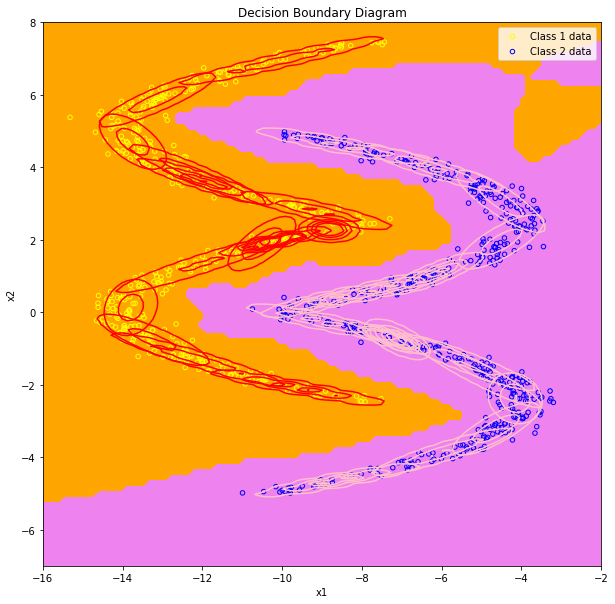

In [ ]:
DecisionBoundaryPlotter([[-16,-2],[-7,8]], [gmm1.mu,gmm2.mu], [gmm1.sigma,gmm2.sigma], X_dev, Y_dev, classifier=classifier)

In [ ]:
def measure_accuracy_syn(gmm1: GMM, gmm2: GMM, X_dev,Y_dev):
    accuracy = 0.
    for i in range(len(X_dev)):
        x = X_dev[i]
        s1 = gmm1.score(x)
        s2 = gmm2.score(x)
        if(s1 > s2):
            if(Y_dev[i] == 1):
                accuracy += 1
            else:
                accuracy -= 1
        elif(s2 > s1):
            if(Y_dev[i] == 2):
                accuracy += 1
            else:
                accuracy -= 1
        else:
            print("Ambigious point")
            # random
            r = np.random.randint(1,3)
            if(r == Y_dev[i]):
                accuracy += 1
            else:
                accuracy -= 1
    accuracy *= 100/len(X_dev)
    return accuracy

In [30]:
def measure_accuracy(classifier, X_dev,Y_dev):
    accuracy = 0.
    for i in tqdm(range(len(X_dev))):
        x = X_dev[i]
        pred = classifier(x)
        if(pred == Y_dev[i]):
            accuracy += 1
    accuracy *= 100/len(X_dev)
    return accuracy

In [31]:
# print(measure_accuracy(classifier, X, Y))
print(measure_accuracy(classifier, X_dev, Y_dev))

  0%|          | 0/12528 [00:00<?, ?it/s]

C:\Users\Vedant\AppData\Local\Temp\ipykernel_33712\29434629.py:39: RuntimeWarning: overflow encountered in exp
  rs = norm_factor*np.exp(-0.5*x_mu*np.linalg.inv(sigma)*x_mu.T)


20.98499361430396


In [32]:
from sklearn.metrics import confusion_matrix
preds = []
for i in tqdm(range(len(X_dev))):
    x = X_dev[i]
    pred = classifier(x)
    preds.append(pred)
mat = confusion_matrix(Y_dev, preds)
print(mat)

  0%|          | 0/12528 [00:00<?, ?it/s]

C:\Users\Vedant\AppData\Local\Temp\ipykernel_33712\29434629.py:39: RuntimeWarning: overflow encountered in exp
  rs = norm_factor*np.exp(-0.5*x_mu*np.linalg.inv(sigma)*x_mu.T)


[[2370  258    0    0    0]
 [2117  259    0    0    0]
 [1634  238    0    0    0]
 [2284  416    0    0    0]
 [2626  326    0    0    0]]


In [162]:
# roc curve
from sklearn.metrics import roc_curve
from scipy.special import softmax

import numpy as np
from sklearn.mixture import GaussianMixture
# Suppose Data X is a 2-D Numpy array (One apple has two features, size and flavor)
_gmm1 = GaussianMixture(n_components=15, random_state=0).fit(X1)
_gmm2 = GaussianMixture(n_components=15, random_state=0).fit(X2)
_gmm3 = GaussianMixture(n_components=15, random_state=0).fit(X3)
_gmm4 = GaussianMixture(n_components=15, random_state=0).fit(X4)
_gmm5 = GaussianMixture(n_components=15, random_state=0).fit(X5)

def _classifier(X):
    s1 = _gmm1.score_samples(X)
    s2 = _gmm2.score_samples(X)
    s3 = _gmm3.score_samples(X)
    s4 = _gmm4.score_samples(X)
    s5 = _gmm5.score_samples(X)
    s = np.array([s1,s2,s3,s4,s5])
    print(s)
    assign = np.argmax(s, axis=0)
    return assign

def _proba(X):
    s1 = _gmm1.score_samples(X)
    s2 = _gmm2.score_samples(X)
    s3 = _gmm3.score_samples(X)
    s4 = _gmm4.score_samples(X)
    s5 = _gmm5.score_samples(X)
    s = np.array([s1,s2,s3,s4,s5])
    return s
    
# try
print(_classifier(X[:2]))
print(Y[:2])

In [156]:
preds = _classifier(X_dev)
acc = np.where(preds == Y_dev)
print(len(acc)/len(X_dev))

[[-34438.01618648 -35589.41619348 -34173.81437698 ... -35068.06231581
  -35450.57220334 -35826.33436094]
 [-35945.34017045 -40154.49129898 -35019.77180508 ... -37293.8944132
  -35733.97205902 -36573.7491848 ]
 [-67626.97649841 -70236.09762214 -59220.95601707 ... -88170.00049604
  -89255.95080695 -80633.71035069]
 [-38527.44433388 -39192.26868195 -37838.19676345 ... -39346.03757761
  -40584.33525831 -39882.31687385]
 [-44718.21100013 -51240.27325883 -44936.23018489 ... -45449.04231931
  -46099.87531243 -46732.2590362 ]]
7.982120051085569e-05


In [157]:
preds = _classifier(X)
acc = np.where(preds == Y)
print(len(acc)/len(X))

[[38.1578368  50.18232458 45.9865214  ... 46.38552501 38.61048038
  38.70483413]
 [31.18683566 42.59700417 39.25414763 ... 38.5956263  34.39746028
  37.25420499]
 [34.4049624  53.71342219 42.19709693 ... 48.25364548 41.25876975
  37.81489587]
 [37.70855682 48.93723806 46.28102132 ... 44.42212034 40.55158711
  40.26577578]
 [39.49837619 49.20164276 46.37105944 ... 46.1793326  36.79400944
  38.21637044]]
2.295684113865932e-05


In [161]:

scores = _proba(X_dev)
TPR = []
FPR = []
scores = np.array(scores)
scores = np.transpose(scores)
print(scores.shape)
min_s = np.min(scores)
max_s = np.max(scores)
thresholds = np.average(scores, axis=1)
thresholds.sort()
for t in tqdm(range(len(thresholds))):
    threshold = thresholds[t]
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(X_dev)):
        for j in range(5):
            if(t == 0):
                print(scores[i][j], X_dev[i], Y_dev[i], threshold, end='\t')
            if(scores[i][j] >= threshold):
                if(Y_dev[i] == j):
                    print("TP")
                    TP += 1
                else:
                    print("FP")
                    FP += 1
            else:
                if(Y_dev[i] == j):
                    print("FN")
                    FN += 1
                else:
                    print("TN")
                    TN += 1
    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))
plt.plot(FPR, TPR)

[[-34438.01618648 -35589.41619348 -34173.81437698 ... -35068.06231581
  -35450.57220334 -35826.33436094]
 [-35945.34017045 -40154.49129898 -35019.77180508 ... -37293.8944132
  -35733.97205902 -36573.7491848 ]
 [-67626.97649841 -70236.09762214 -59220.95601707 ... -88170.00049604
  -89255.95080695 -80633.71035069]
 [-38527.44433388 -39192.26868195 -37838.19676345 ... -39346.03757761
  -40584.33525831 -39882.31687385]
 [-44718.21100013 -51240.27325883 -44936.23018489 ... -45449.04231931
  -46099.87531243 -46732.2590362 ]]
(12528,)


AxisError: axis 1 is out of bounds for array of dimension 1